In [1]:
import os
import sys
import json
from datetime import datetime

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

In [4]:
# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment_gym as env_gym
import environment_gym_rs2 as env_gym_rs2
import utilities as util

# Load the TensorBoard extension
# %reload_ext tensorboard

## Reward Shaping Method 2

- Apply reward (150 * new clearance rate) to good lane switch
- Apply penalty to impossible lane switch (switch left when lane = 1 and switch right when lane = 5)

### Train Model 4

In [13]:
# Initialize and vectorize the environment
env = env_gym_rs2.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
env.reset()
eval_env = Monitor(env_gym_rs2.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/ppo_rs2_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env, 
            verbose = 1,
            tensorboard_log = log_dir
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_rs3_model/PPO_9


Eval num_timesteps=1000, episode_reward=-13569.00 +/- 10717.74
Episode length: 1756.60 +/- 1071.42
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.76e+03  |
|    mean_reward     | -1.36e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-11495.00 +/- 15170.76
Episode length: 1549.20 +/- 1516.59
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.55e+03  |
|    mean_reward     | -1.15e+04 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 634      |
|    ep_rew_mean     | 3.71e+04 |
| time/              |          |
|    fps             | 169      |
|    iterations      | 1        |
|    time_elapsed    | 12     

### Test Model 4

In [ ]:
# Load the best baseline model
log_dir = "./logs/ppo_rs2_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = PPO.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [ ]:
# Test the model
num_episodes = 1000
file_name = 'ppo_rs2_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

### Analysis of Model 4

Average reward of 1000 episodes is -4903.
Average timesteps of 1000 episodes is 1042.


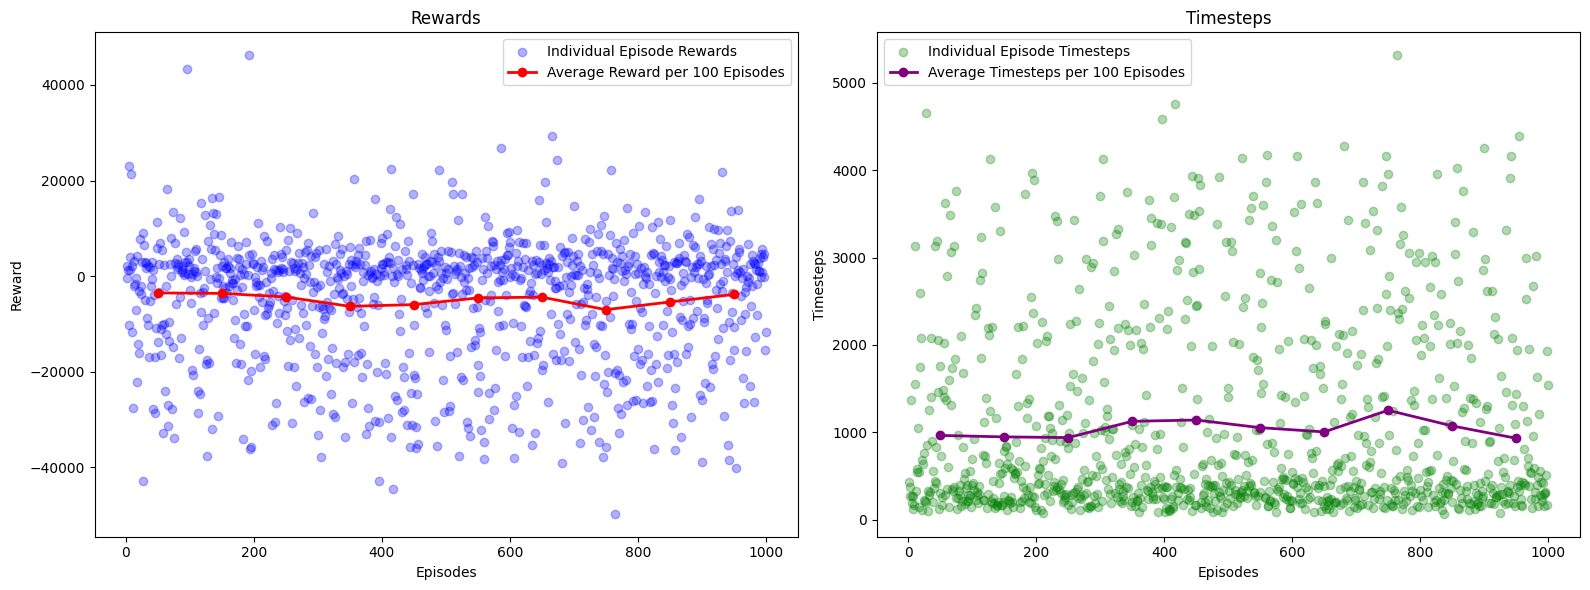

In [11]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

In [ ]:
util.plot_test_boxplots(file_name=file_name)

In [12]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)

Total actions across 1000 episodes: 1042499
Action -1: 0.0%
Action 0: 98.0%
Action 1: 1.9%

Total timesteps across 1000 episodes (including initial states): 1043499
Lane 1:
  77.4% of timesteps had a clearance rate less than 5
  87.9% of timesteps had a clearance rate less than 10
Lane 2:
  77.0% of timesteps had a clearance rate less than 5
  87.6% of timesteps had a clearance rate less than 10
Lane 3:
  76.8% of timesteps had a clearance rate less than 5
  87.2% of timesteps had a clearance rate less than 10
Lane 4:
  76.8% of timesteps had a clearance rate less than 5
  87.0% of timesteps had a clearance rate less than 10
Lane 5:
  77.2% of timesteps had a clearance rate less than 5
  87.2% of timesteps had a clearance rate less than 10


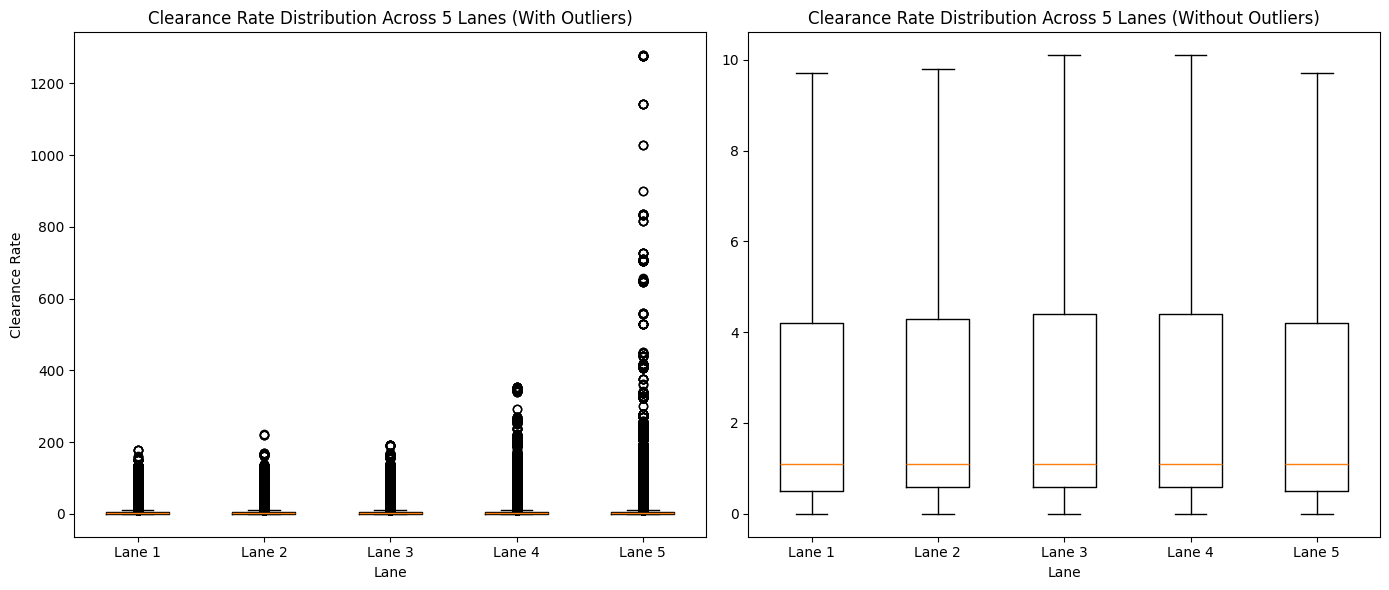

In [13]:
util.plot_clearance_rate_boxplots(log_file=file_name)